<a href="https://colab.research.google.com/github/lu150ml/GS_machine_learning/blob/main/gs_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Luís Henrique Ribeiro Rm559100
## Matheu Henrique Portapila Rm554481
## Ryan Sales Fernandes Rm558397

## Import geral

In [ ]:
PATH = '/content/startup data (1).csv'   # ajuste se necessário
df = pd.read_csv(PATH)

print(df.shape)
print(df.sample(3))
print(df.columns.tolist())

(923, 49)
     Unnamed: 0 state_code   latitude   longitude zip_code       id  \
842         122         FL  28.666770  -81.392794    32714  c:14483   
6           195         CA  37.391559 -122.070264    94041  c:16191   
113         695         CA  37.456040 -122.165399    94025   c:3986   

                  city Unnamed: 6                   name  labels  ...  \
842  Altamonte Springs        NaN            Hit Systems       0  ...   
6        Mountain View        NaN  RingCube Technologies       1  ...   
113         Menlo Park        NaN                 Krugle       1  ...   

    object_id has_VC has_angel has_roundA  has_roundB  has_roundC  has_roundD  \
842   c:14483      0         1          0           0           0           0   
6     c:16191      1         0          1           1           0           0   
113    c:3986      0         0          0           1           0           0   

     avg_participants  is_top500    status  
842            1.0000          0    closed

In [ ]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)

from scipy.stats import randint, uniform

import shap

import warnings
warnings.filterwarnings("ignore")  # opcional para reduzir verbosidade

## 1 Análise exploratória e preparação dos dados

### Contagem das startups adquiridas vs fechadas


In [ ]:
print(df['status'].value_counts(normalize=True))


status
acquired    0.646804
closed      0.353196
Name: proportion, dtype: float64


### Distribuições geográficas e setoriais

In [ ]:
# Estados
df['state_code'].value_counts().head()

# Categorias
df['category_code'].value_counts().head(10)


,count
category_code,
software,153
web,144
mobile,79
enterprise,73
advertising,62
games_video,52
semiconductor,35
biotech,34
network_hosting,34


### Contagem de nulos


In [ ]:
missing = df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)


,0
closed_at,588
Unnamed: 6,493
age_first_milestone_year,152
age_last_milestone_year,152
state_code.1,1


In [ ]:
# Removendo colunas inúteis
df = df.drop(columns=['Unnamed: 6', 'closed_at', 'state_code.1'], errors='ignore')

#  Imputar colunas numéricas com média
for col in ['age_first_milestone_year', 'age_last_milestone_year']:
    df[col] = df[col].fillna(df[col].mean())

# Verificar se tudo foi preenchido
print(df.isnull().sum().sum())  # deve retornar 0


0


## Advanced Feature Engineering

Funding médio por rodada

In [ ]:
df['funding_per_round'] = df['funding_total_usd'] / (df['funding_rounds'] + 1)


Tempo entre o primeiro e o último financiamento

In [ ]:
df['funding_span'] = df['age_last_funding_year'] - df['age_first_funding_year']


Número total de rodadas relevantes

In [ ]:
round_cols = ['has_roundA', 'has_roundB', 'has_roundC', 'has_roundD']
df['num_rounds_active'] = df[round_cols].astype(int).sum(axis=1)


Relação entre relacionamentos e investimento

In [ ]:
df['rel_invest_ratio'] = df['relationships'] / (df['funding_total_usd'] + 1)


Indicador de “High Value VC”

In [ ]:
df['vc_investment_strength'] = df['has_VC'].astype(int) * df['funding_total_usd']


Visualizando as novas colunas

In [ ]:
df[['funding_per_round', 'funding_span', 'num_rounds_active',
    'rel_invest_ratio', 'vc_investment_strength']].describe()


,funding_per_round,funding_span,num_rounds_active,rel_invest_ratio,vc_investment_strength
count,9.230000e+02,923.000000,923.000000,9.230000e+02,9.230000e+02
mean,6.454104e+06,1.695826,1.232936,5.452648e-06,9.183487e+06
std,3.818690e+07,1.936531,1.041919,2.423588e-05,2.873315e+07
min,3.666667e+03,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,1.000000e+06,0.000000,0.000000,2.136791e-07,0.000000e+00
50%,3.250000e+06,1.085000,1.000000,6.315789e-07,0.000000e+00
75%,6.714250e+06,2.794550,2.000000,2.073039e-06,5.000000e+06
max,1.140000e+09,10.819200,4.000000,4.545041e-04,5.100000e+08


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923 entries, 0 to 922
Data columns (total 51 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                923 non-null    int64  
 1   state_code                923 non-null    object 
 2   latitude                  923 non-null    float64
 3   longitude                 923 non-null    float64
 4   zip_code                  923 non-null    object 
 5   id                        923 non-null    object 
 6   city                      923 non-null    object 
 7   name                      923 non-null    object 
 8   labels                    923 non-null    int64  
 9   founded_at                923 non-null    object 
 10  first_funding_at          923 non-null    object 
 11  last_funding_at           923 non-null    object 
 12  age_first_funding_year    923 non-null    float64
 13  age_last_funding_year     923 non-null    float64
 14  age_first_

### Preparando para modelagem

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['status'] = le.fit_transform(df['status'])

# Checar resultado
print(df['status'].value_counts())


status
0    597
1    326
Name: count, dtype: int64


In [ ]:
cols_to_drop = [
    'Unnamed: 0', 'id', 'object_id', 'zip_code',
    'city', 'name', 'founded_at', 'first_funding_at', 'last_funding_at'
]
df = df.drop(columns=cols_to_drop, errors='ignore')



In [ ]:
# Verificar colunas não numéricas
non_numeric_cols = df.select_dtypes(include=['object']).columns
print(non_numeric_cols)


Index(['state_code', 'category_code'], dtype='object')


In [ ]:
# Converter colunas categóricas em dummies


# 1️⃣ Remover o target e a coluna 'labels'
X = df.drop(columns=['status', 'labels'], errors='ignore')
y = df['status']

non_numeric_cols = X.select_dtypes(include=['object']).columns

X = pd.get_dummies(X, columns=non_numeric_cols, drop_first=True)

# Recriar as divisões com as novas colunas numéricas
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Conjuntos recriados com colunas numéricas:")
print(X_train.shape, X_valid.shape, X_test.shape)


Conjuntos recriados com colunas numéricas:
(646, 106) (138, 106) (139, 106)


Dividindo treino e teste

## Treinamento Tree decision

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

dt = DecisionTreeClassifier(max_depth=5, min_samples_split=10, random_state=42)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_valid)
print("Accuracy:", accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred))


Accuracy: 0.6739130434782609
              precision    recall  f1-score   support

           0       0.77      0.71      0.74        89
           1       0.54      0.61      0.57        49

    accuracy                           0.67       138
   macro avg       0.65      0.66      0.65       138
weighted avg       0.69      0.67      0.68       138



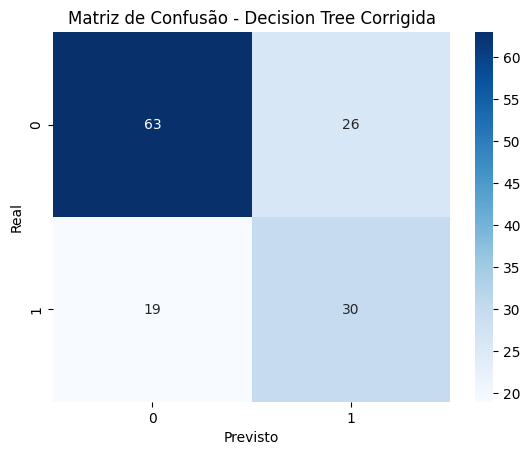

In [ ]:
cm = confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão - Decision Tree Corrigida")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()


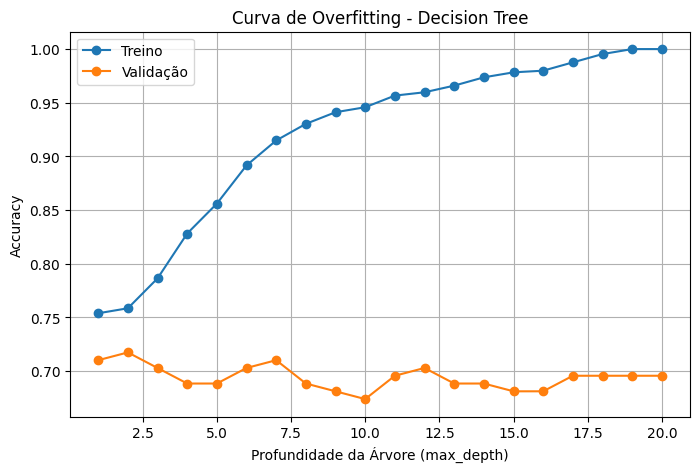

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

train_scores, valid_scores = [], []
depths = range(1, 21)

for d in depths:
    model = DecisionTreeClassifier(max_depth=d, random_state=42)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    valid_pred = model.predict(X_valid)
    train_scores.append(accuracy_score(y_train, train_pred))
    valid_scores.append(accuracy_score(y_valid, valid_pred))

plt.figure(figsize=(8,5))
plt.plot(depths, train_scores, marker='o', label="Treino")
plt.plot(depths, valid_scores, marker='o', label="Validação")
plt.xlabel("Profundidade da Árvore (max_depth)")
plt.ylabel("Accuracy")
plt.title("Curva de Overfitting - Decision Tree")
plt.legend()
plt.grid(True)
plt.show()


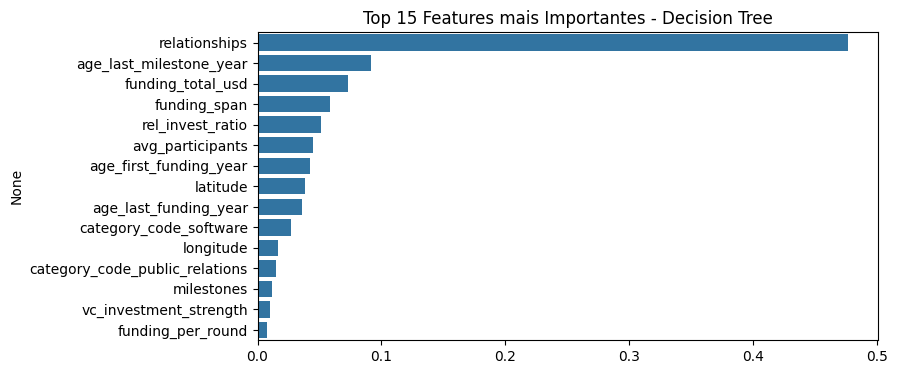

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

importances = pd.Series(dt.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(8,4))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Top 15 Features mais Importantes - Decision Tree")
plt.show()


## Modelagem avançada

In [ ]:
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
from sklearn.preprocessing import StandardScaler

# Criar e ajustar o scaler apenas com os dados de treino
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# 1️⃣ XGBoost (sem normalização)
xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    eval_metric='logloss'
)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_valid)

# 2️⃣ SVM (com dados escalados)
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)
svm_pred = svm.predict(X_valid_scaled)

# 3️⃣ MLP (com dados escalados)
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
mlp.fit(X_train_scaled, y_train)
mlp_pred = mlp.predict(X_valid_scaled)


In [ ]:
models = {
    'XGBoost': xgb_pred,
    'SVM': svm_pred,
    'MLP': mlp_pred
}

for name, preds in models.items():
    print(f"\n🔹 {name}")
    print("Accuracy:", accuracy_score(y_valid, preds))
    print(classification_report(y_valid, preds))



🔹 XGBoost
Accuracy: 0.7536231884057971
              precision    recall  f1-score   support

           0       0.82      0.79      0.80        89
           1       0.64      0.69      0.67        49

    accuracy                           0.75       138
   macro avg       0.73      0.74      0.74       138
weighted avg       0.76      0.75      0.76       138


🔹 SVM
Accuracy: 0.7608695652173914
              precision    recall  f1-score   support

           0       0.79      0.87      0.82        89
           1       0.70      0.57      0.63        49

    accuracy                           0.76       138
   macro avg       0.74      0.72      0.73       138
weighted avg       0.76      0.76      0.75       138


🔹 MLP
Accuracy: 0.6594202898550725
              precision    recall  f1-score   support

           0       0.76      0.70      0.73        89
           1       0.52      0.59      0.55        49

    accuracy                           0.66       138
   macro avg    

### Modelo ensemble


🔹 Ensemble Voting Classifier
Accuracy: 0.7681159420289855
              precision    recall  f1-score   support

           0       0.81      0.84      0.82        89
           1       0.69      0.63      0.66        49

    accuracy                           0.77       138
   macro avg       0.75      0.74      0.74       138
weighted avg       0.76      0.77      0.77       138



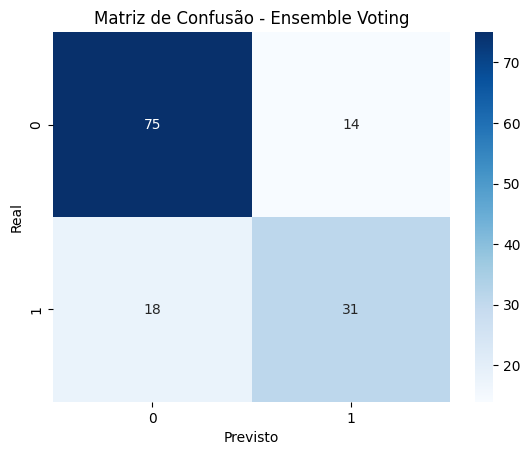

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

ensemble = VotingClassifier(
    estimators=[('xgb', xgb), ('svm', svm), ('mlp', mlp)],
    voting='soft',
    weights=[3,1,1]  # mais peso ao XGBoost
)


ensemble.fit(X_train, y_train)
ens_pred = ensemble.predict(X_valid)

print("\n🔹 Ensemble Voting Classifier")
print("Accuracy:", accuracy_score(y_valid, ens_pred))
print(classification_report(y_valid, ens_pred))

# Matriz de confusão
cm = confusion_matrix(y_valid, ens_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão - Ensemble Voting")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()


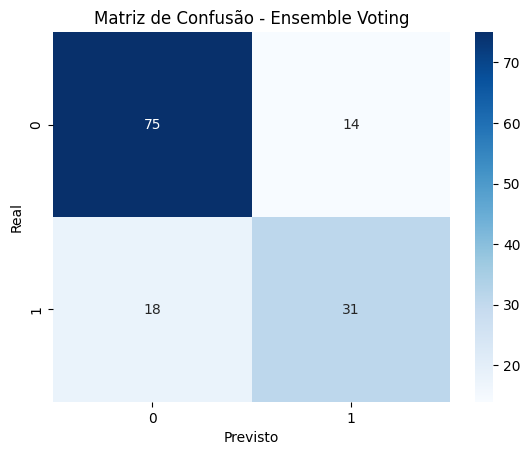

In [ ]:
cm = confusion_matrix(y_valid, ens_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão - Ensemble Voting")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()


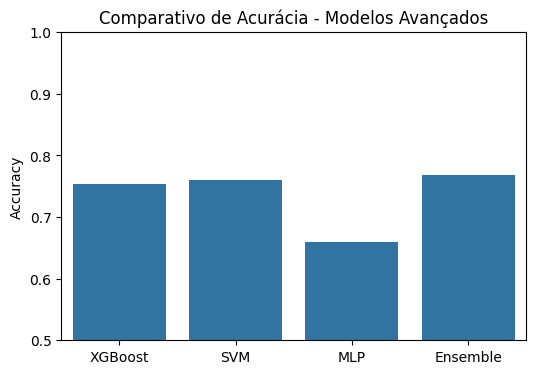

In [ ]:
accuracies = {
    'XGBoost': accuracy_score(y_valid, xgb_pred),
    'SVM': accuracy_score(y_valid, svm_pred),
    'MLP': accuracy_score(y_valid, mlp_pred),
    'Ensemble': accuracy_score(y_valid, ens_pred)
}

plt.figure(figsize=(6,4))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.title("Comparativo de Acurácia - Modelos Avançados")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1)
plt.show()


## Hyperparameter

Importando modelo base

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Modelo base
xgb = XGBClassifier(
    random_state=42,
    eval_metric='logloss'
)


Passando os parametros

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0],
    'gamma': [0, 0.1, 0.3]
}


Treinando o GridSearch

In [ ]:
grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("Melhores parâmetros encontrados:")
print(grid.best_params_)
print("\nMelhor F1 (cross-validation):", grid.best_score_)


Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Melhores parâmetros encontrados:
{'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}

Melhor F1 (cross-validation): 0.6505420591737685


In [ ]:
best_xgb = grid.best_estimator_
best_xgb.fit(X_train, y_train)

y_pred_best = best_xgb.predict(X_valid)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("🔹 XGBoost Otimizado")
print("Accuracy:", accuracy_score(y_valid, y_pred_best))
print(classification_report(y_valid, y_pred_best))


🔹 XGBoost Otimizado
Accuracy: 0.7608695652173914
              precision    recall  f1-score   support

           0       0.81      0.82      0.82        89
           1       0.67      0.65      0.66        49

    accuracy                           0.76       138
   macro avg       0.74      0.74      0.74       138
weighted avg       0.76      0.76      0.76       138



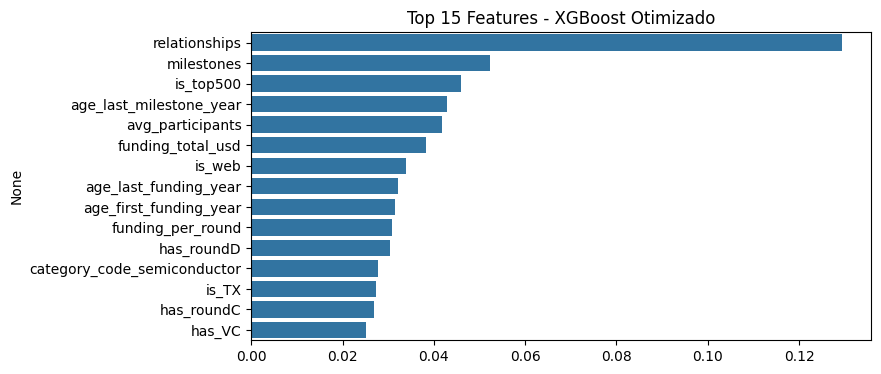

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

importances = pd.Series(best_xgb.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(8,4))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Top 15 Features - XGBoost Otimizado")
plt.show()


## Explicabilidade

In [ ]:
import shap
import numpy as np

# Inicializar o explicador para o modelo XGBoost otimizado
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_valid)


### Importância global

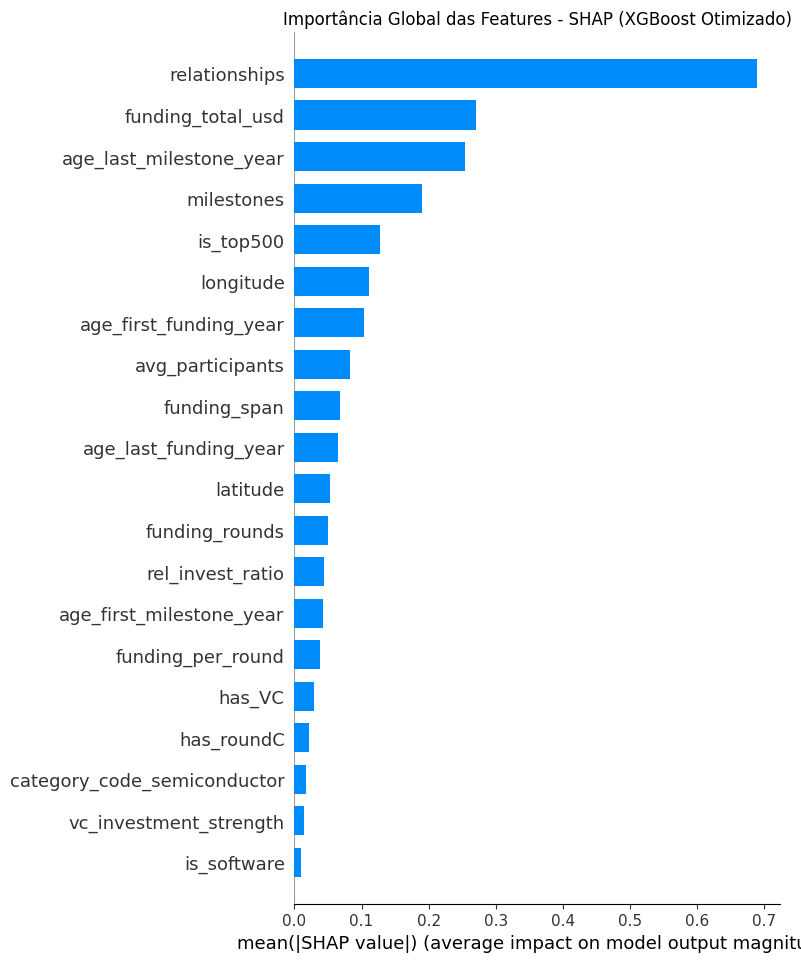

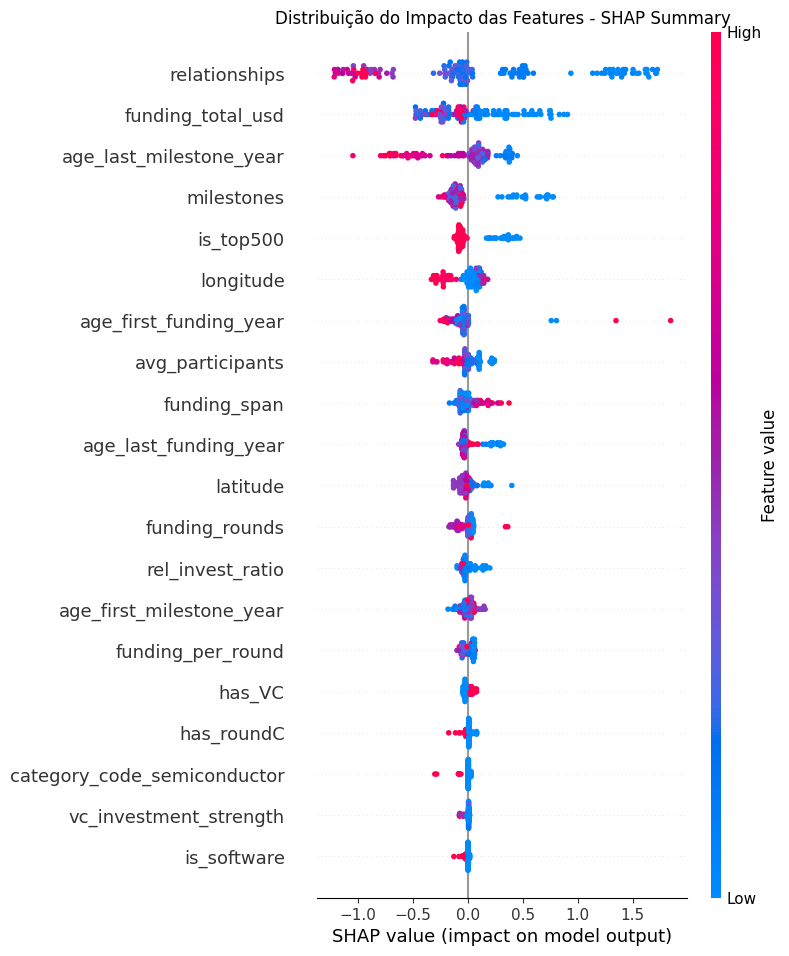

In [ ]:
# Gráfico de importância média absoluta
shap.summary_plot(shap_values, X_valid, plot_type="bar", show=False)
plt.title("Importância Global das Features - SHAP (XGBoost Otimizado)")
plt.show()

# Gráfico detalhado com direção do impacto (positivo → aquisição, negativo → fechamento)
shap.summary_plot(shap_values, X_valid, show=False)
plt.title("Distribuição do Impacto das Features - SHAP Summary")
plt.show()


### Interpretação Global — Fatores que Aumentam a Chance de Aquisição

Com base na análise SHAP do modelo XGBoost otimizado, as variáveis com valores SHAP positivos estão mais associadas ao aumento da probabilidade de aquisição. Esses fatores têm impacto direto sobre a classe “adquirida (1)”, deslocando a predição do modelo para o lado positivo.

#### 1. relationships

Empresas com maior número de relacionamentos corporativos tendem a apresentar maior probabilidade de aquisição. Essa variável reflete o grau de integração da startup com o ecossistema de negócios, investidores e parceiros. Um alto número de conexões sugere acesso a capital, oportunidades de parceria e visibilidade de mercado.

#### 2. age_last_milestone_year

Startups que atingiram milestones recentemente possuem maior chance de aquisição. Valores altos indicam atividade contínua e inovação recente, o que demonstra vitalidade operacional e interesse de investidores ou compradores estratégicos.

#### 3. funding_total_usd

O total de investimento captado é uma variável crítica. Um valor elevado de funding_total_usd demonstra confiança de mercado, boa capacidade de captação de recursos e potencial de crescimento, tornando a empresa um alvo mais atrativo para aquisição.

#### 4. milestones

A quantidade de marcos alcançados reflete maturidade e capacidade de execução. Empresas que atingem mais milestones geralmente possuem maior estabilidade e histórico de conquistas, o que reduz o risco percebido e aumenta o valor estratégico.

#### 5. is_top500

Startups listadas entre as 500 mais relevantes (em rankings de inovação ou crescimento) possuem maior exposição e credibilidade. Essa variável está associada a reputação, visibilidade e reconhecimento no mercado, fatores que aumentam o interesse de investidores.

#### 6. avg_participants

Rodadas de investimento com maior número médio de participantes indicam confiança distribuída entre diversos investidores. Esse fator reduz o risco individual de investimento e reforça a percepção de robustez financeira da empresa.

#### 7. funding_span

O intervalo de tempo entre a primeira e a última rodada de investimento é um indicador de longevidade e manutenção de confiança. Startups que continuam a atrair capital ao longo dos anos demonstram estabilidade e sustentabilidade.


### Interpretação Global — Fatores que Indicam Maior Risco de Fechamento

As variáveis com valores SHAP negativos exercem impacto contrário, reduzindo a probabilidade de aquisição e aumentando o risco de fechamento. Esses fatores são interpretados como sinais de vulnerabilidade operacional ou enfraquecimento da posição de mercado.

#### 1. age_first_milestone_year

Startups cujo primeiro milestone ocorreu há muitos anos tendem a apresentar menor probabilidade de aquisição. Isso indica que o ritmo de inovação pode ter diminuído, ou que a empresa está estagnada em termos de desenvolvimento tecnológico e comercial.

#### 2. latitude e longitude

Algumas localizações geográficas podem estar associadas a ecossistemas menos dinâmicos de inovação. Startups distantes de polos tecnológicos globais costumam ter menos acesso a capital de risco e redes estratégicas, o que reduz a chance de aquisição.

#### 3. funding_per_round

Um valor baixo de investimento médio por rodada sugere dificuldade de captação ou baixa atratividade para investidores. Isso pode refletir problemas de escalabilidade ou falta de confiança no modelo de negócio.

#### 4. rel_invest_ratio

Um baixo índice de reinvestimento (investidores que voltam a aportar capital) é um sinal negativo. Isso demonstra que investidores anteriores não estão dispostos a continuar financiando o crescimento, o que indica fragilidade.

#### 5. has_VC

A ausência de participação de venture capital reduz a visibilidade e o suporte estratégico da empresa. Startups sem apoio de fundos estruturados têm menor capacidade de expansão e menor chance de atingir níveis de aquisição.

#### 6. category_code_semiconductor, is_software

Certos segmentos de atuação podem apresentar maior saturação ou ciclo de maturidade tecnológica avançado. Startups inseridas em setores muito competitivos ou de retorno mais lento têm menor probabilidade de serem adquiridas.

#### 7. vc_investment_strength

Baixos valores dessa variável indicam ecossistemas de investimento pouco desenvolvidos ao redor da startup. Esse fator reflete a dificuldade de atrair grandes rodadas e investidores relevantes, aumentando o risco de fechamento.

#### 8. has_roundC

A ausência de rodadas intermediárias (como série C) pode indicar interrupção no ciclo de financiamento. Startups que não conseguem progredir entre as fases de investimento apresentam risco elevado de descontinuidade.


### Seleção de 5 Startups Adquiridas (Classe 1)

In [ ]:
acquired_idx = X_valid[y_valid == 1].sample(5, random_state=42).index

# Criar subconjunto de startups adquiridas
X_acquired = X_valid.loc[acquired_idx]
y_acquired = y_valid.loc[acquired_idx]

print("Startups Adquiridas Selecionadas:")
display(X_acquired.assign(status_real=y_acquired))

Startups Adquiridas Selecionadas:


,latitude,longitude,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,...,category_code_search,category_code_security,category_code_semiconductor,category_code_social,category_code_software,category_code_sports,category_code_transportation,category_code_travel,category_code_web,status_real
22,37.426316,-122.141082,5.4904,5.4904,0.0000,0.0000,1,1,3170000,1,...,False,False,False,False,False,False,False,False,True,1
301,37.384239,-122.012475,1.9151,2.5808,2.0000,6.9178,10,2,3600000,3,...,False,False,False,False,False,False,False,False,True,1
331,33.133524,-117.254593,5.5671,8.5342,5.6055,7.8384,3,3,36300000,2,...,False,False,False,False,False,False,False,False,False,1
439,38.223032,-122.261642,2.4438,7.1973,-2.0575,6.8767,6,3,25500100,3,...,False,False,False,False,True,False,False,False,False,1
467,40.750519,-73.993494,2.0000,2.0000,1.0274,3.1644,8,1,200000,3,...,False,False,False,False,False,False,False,False,False,1


In [ ]:
### Seleção de 5 Startups Fechadas (Classe 0)


In [ ]:

closed_idx = X_valid[y_valid == 0].sample(5, random_state=42).index

# Criar subconjunto de startups fechadas
X_closed = X_valid.loc[closed_idx]
y_closed = y_valid.loc[closed_idx]

print("Startups Fechadas Selecionadas:")
display(X_closed.assign(status_real=y_closed))



Startups Fechadas Selecionadas:


,latitude,longitude,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,...,category_code_search,category_code_security,category_code_semiconductor,category_code_social,category_code_software,category_code_sports,category_code_transportation,category_code_travel,category_code_web,status_real
442,37.763652,-122.421778,0.1671,0.1671,0.6712,3.3151,4,1,500000,2,...,False,False,False,False,False,False,False,False,False,0
52,30.321464,-97.755010,0.7479,0.7479,4.0493,8.3233,12,1,5000000,5,...,False,False,False,False,False,False,False,False,True,0
440,37.779281,-122.419236,0.2959,0.2959,1.5863,1.6658,3,1,400000,2,...,False,False,False,False,False,False,False,False,True,0
813,37.506885,-122.247573,0.3370,5.2301,4.1726,5.7205,13,4,53000000,3,...,False,False,False,False,False,False,False,False,False,0
552,37.288326,-121.945633,1.1589,1.1589,-0.0658,2.9616,3,1,205000,3,...,False,False,False,False,False,False,False,False,True,0


#### Combinação e Exibição Final dos 10 Casos Selecionados


In [ ]:

# Combinar índices das startups adquiridas e fechadas
selected_idx = list(acquired_idx) + list(closed_idx)

# Criar subconjunto consolidado
X_valid_selected = X_valid.loc[selected_idx]
y_valid_selected = y_valid.loc[selected_idx]

print("Resumo das 10 Startups Selecionadas para Explicabilidade Local (SHAP):")
display(pd.DataFrame({
    "Index": selected_idx,
    "Status Real": y_valid_selected
}))


Resumo das 10 Startups Selecionadas para Explicabilidade Local (SHAP):


,Index,Status Real
22,22,1
301,301,1
331,331,1
439,439,1
467,467,1
442,442,0
52,52,0
440,440,0
813,813,0
552,552,0


### Gere Shap Force plot e Waterfall plot para os 10 cliente selecionados acima



Caso 1 - Índice 22


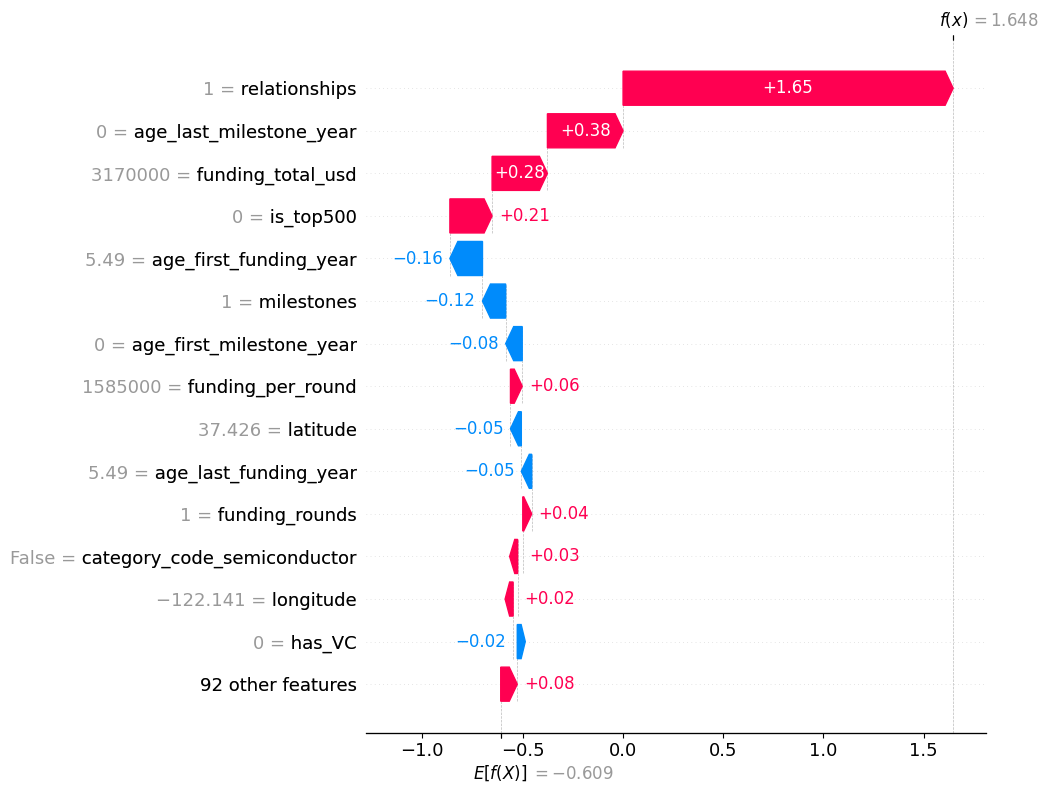

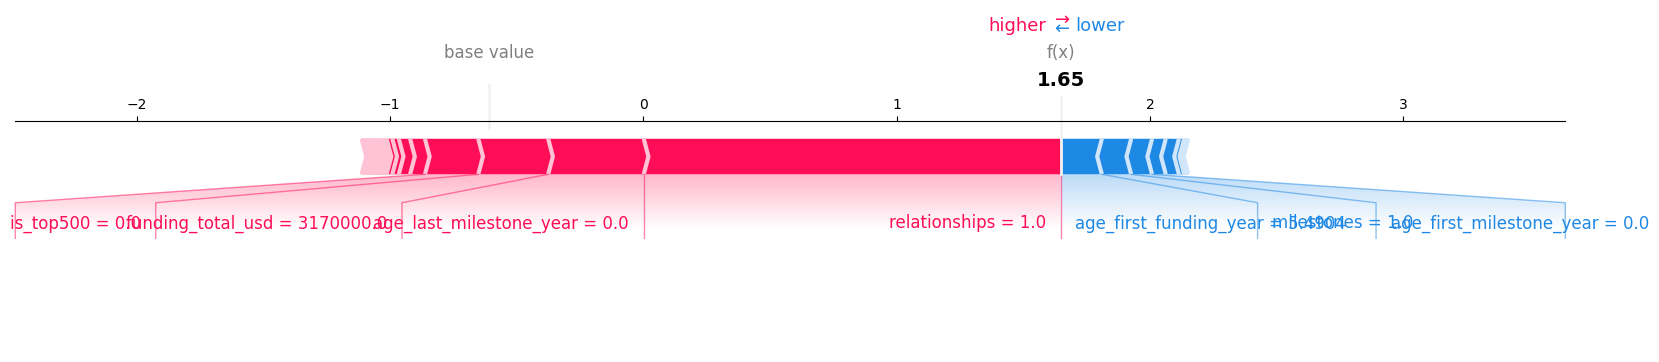


Caso 2 - Índice 301


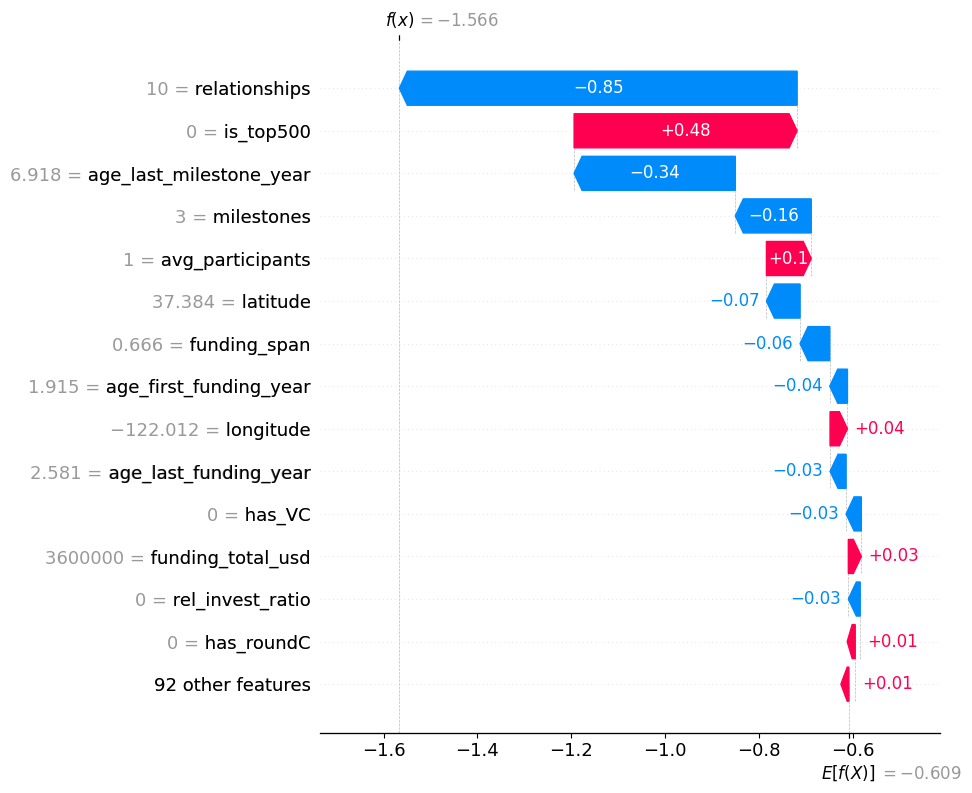

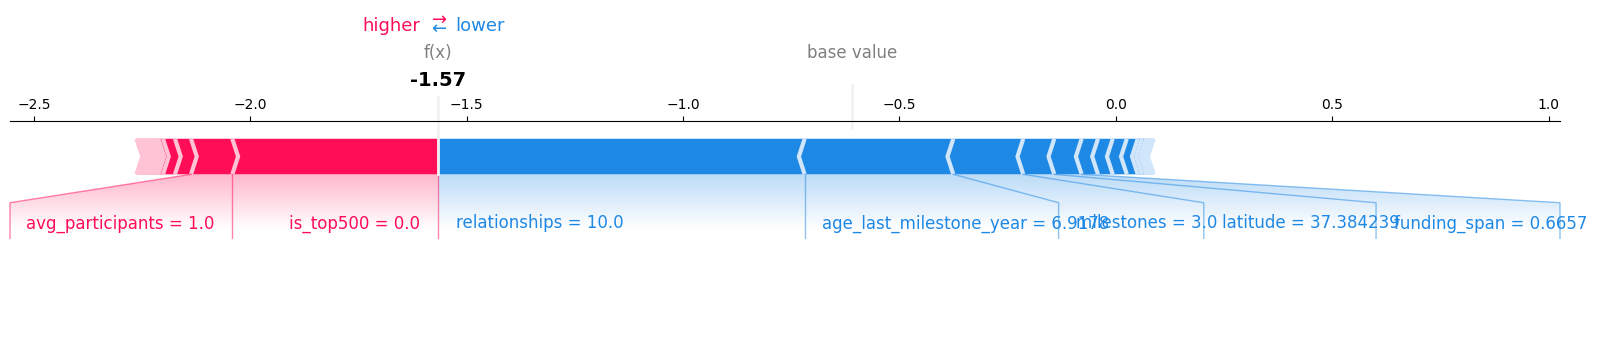


Caso 3 - Índice 331


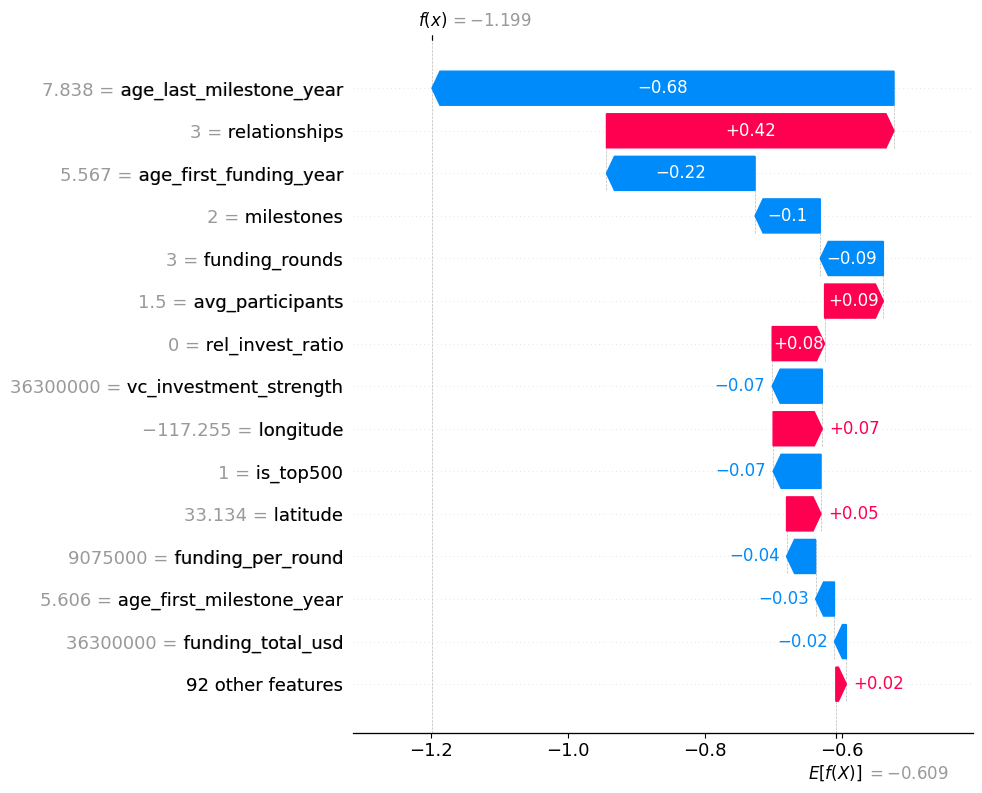

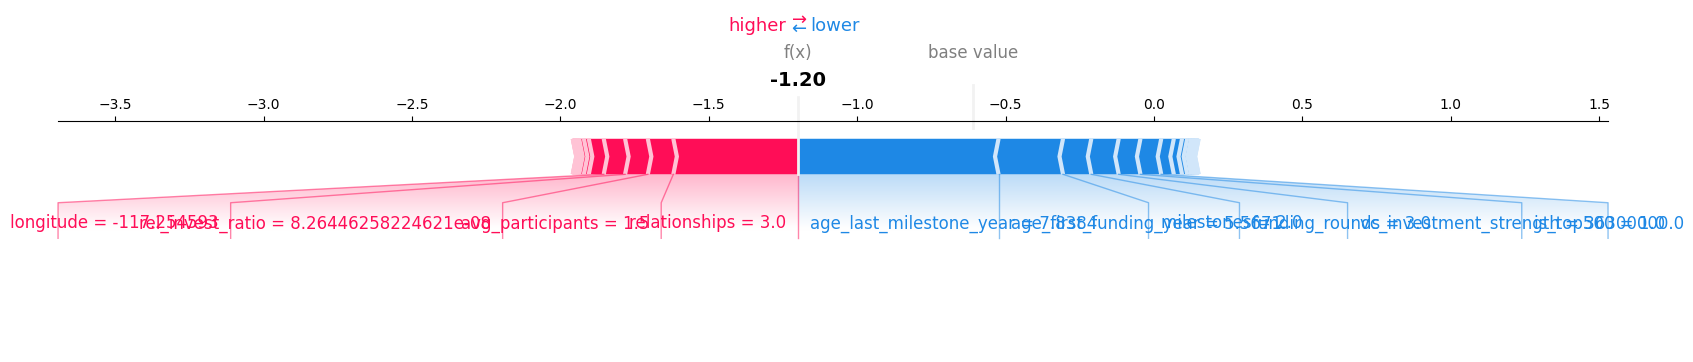


Caso 4 - Índice 439


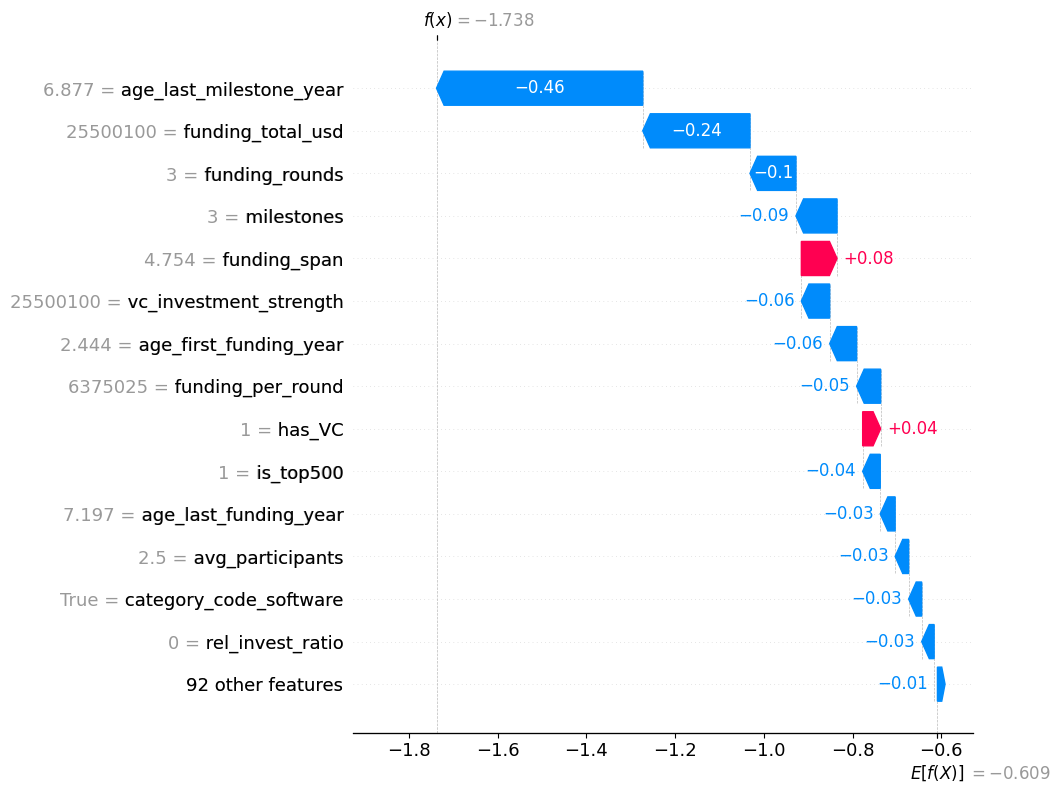

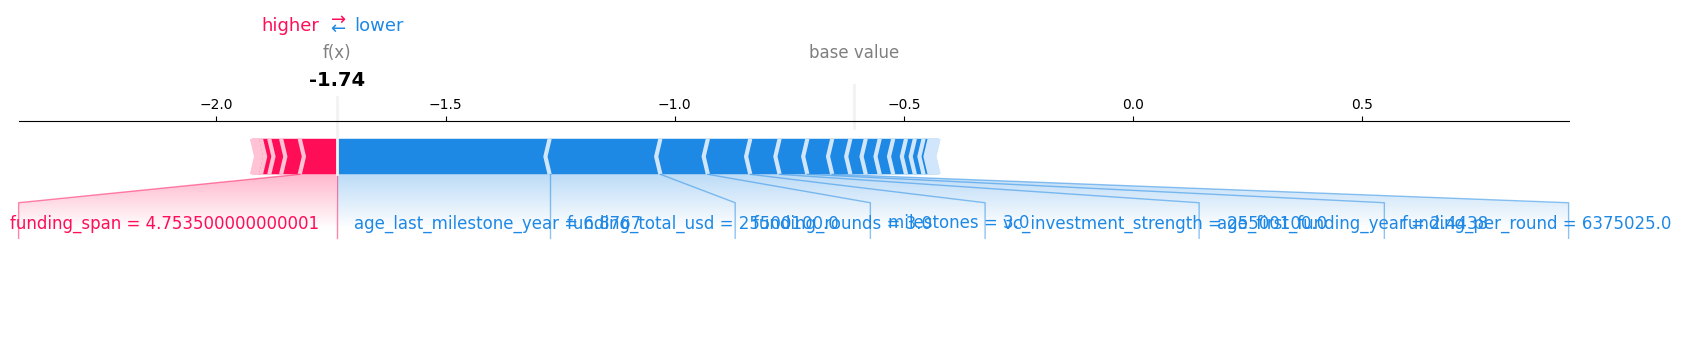


Caso 5 - Índice 467


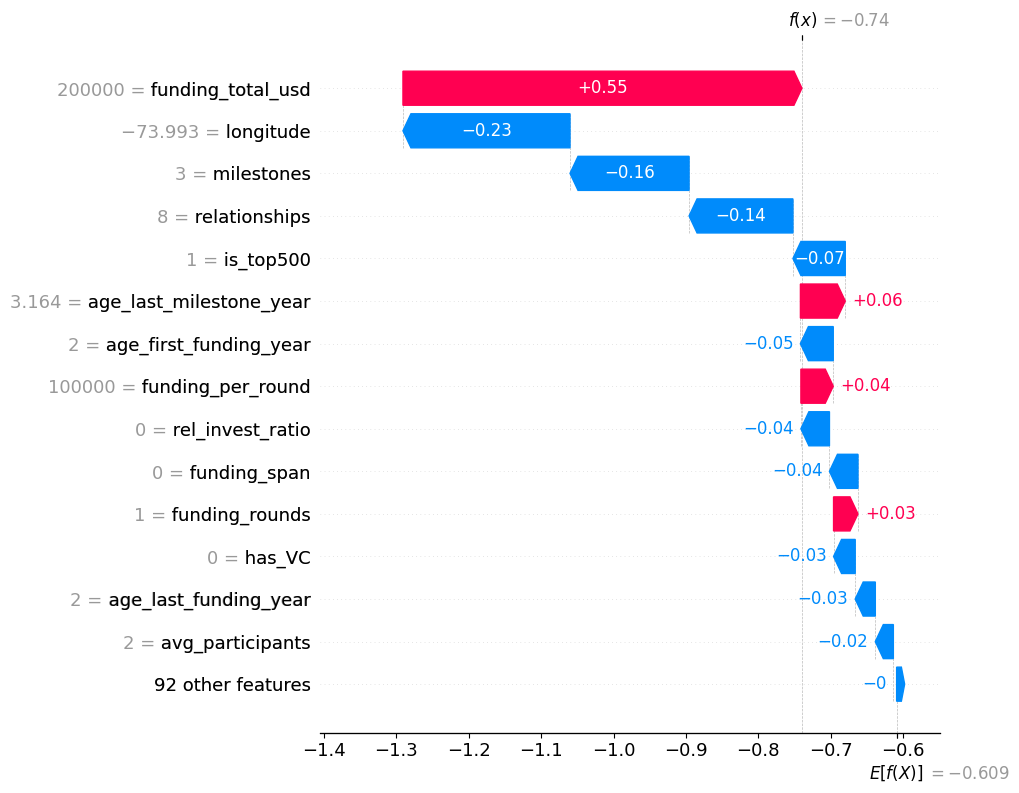

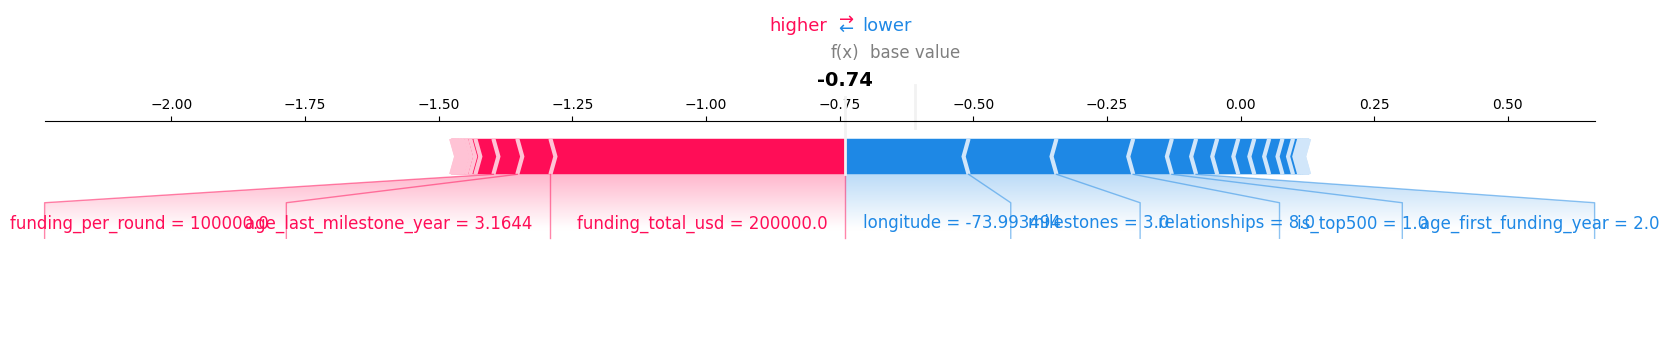


Caso 6 - Índice 442


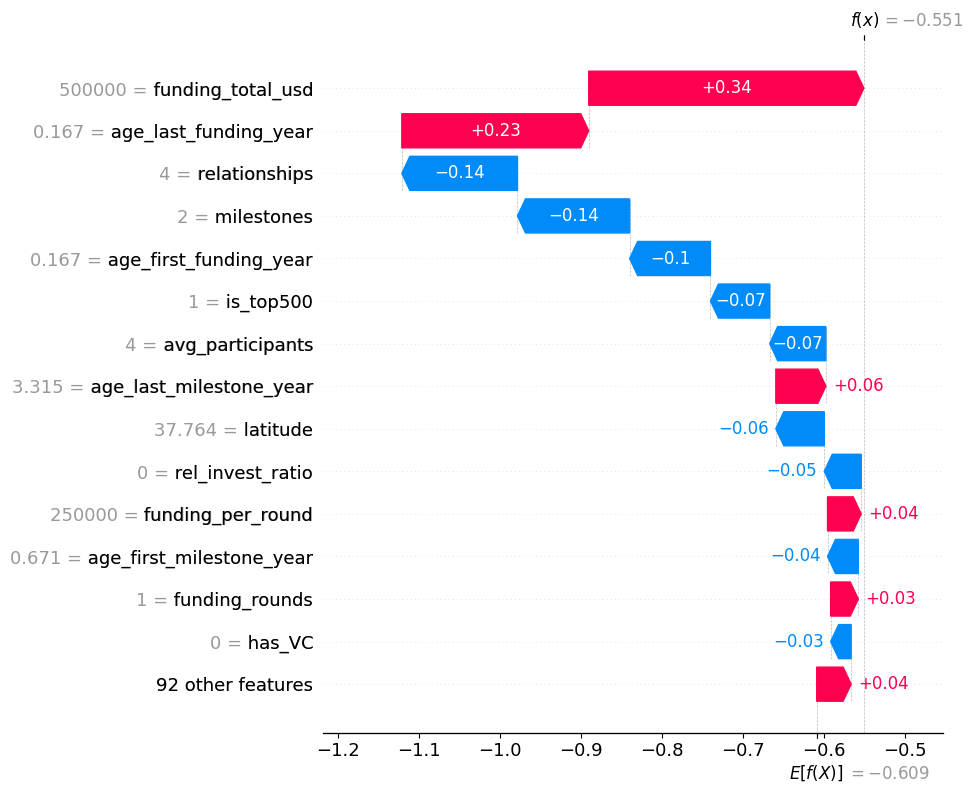

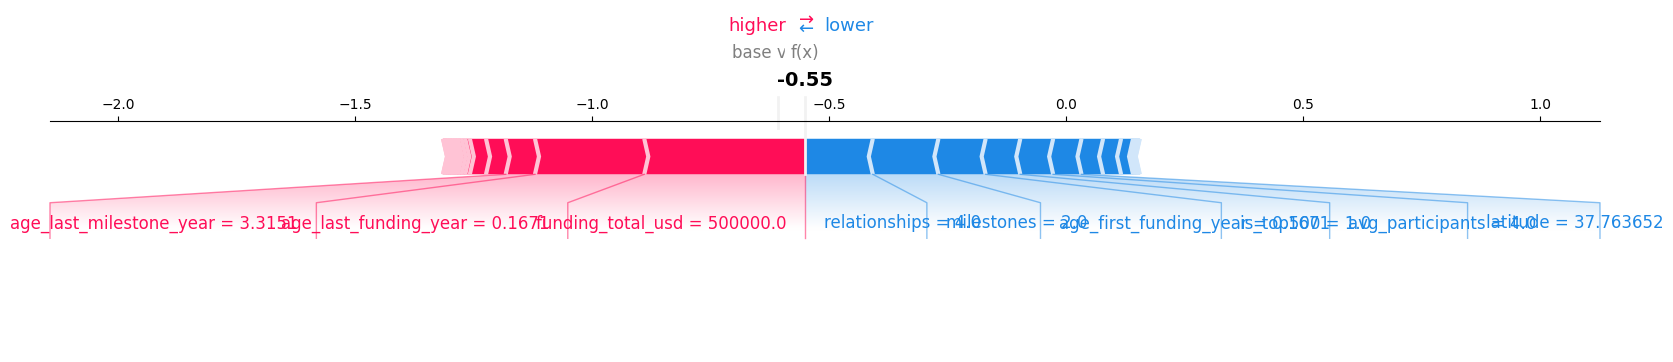


Caso 7 - Índice 52


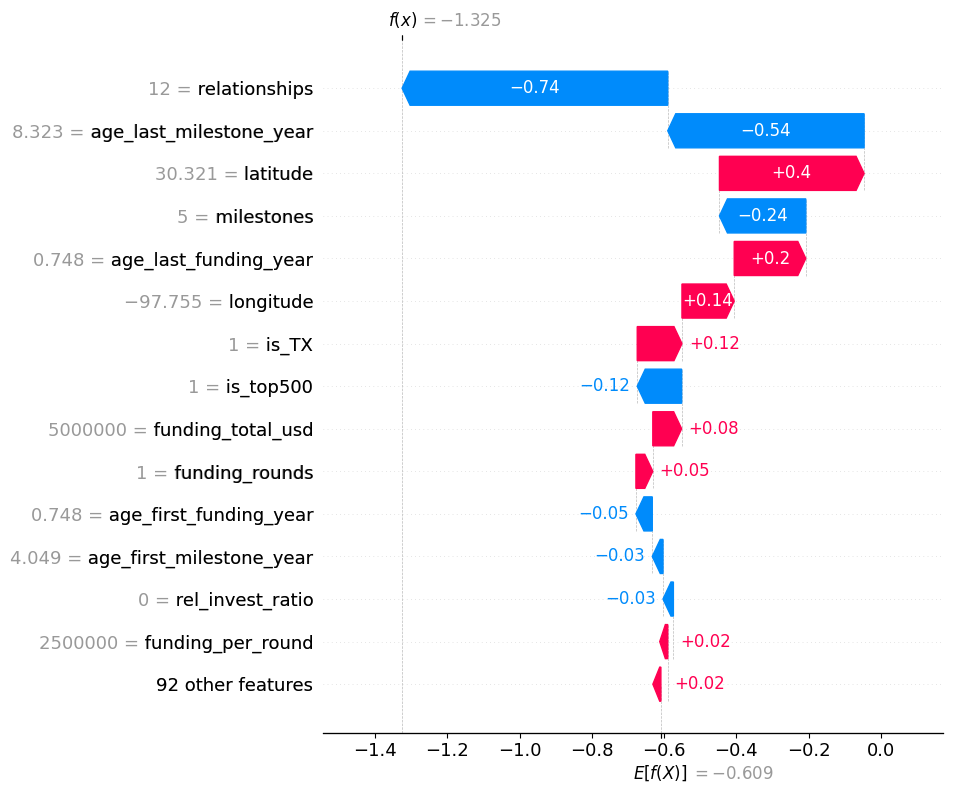

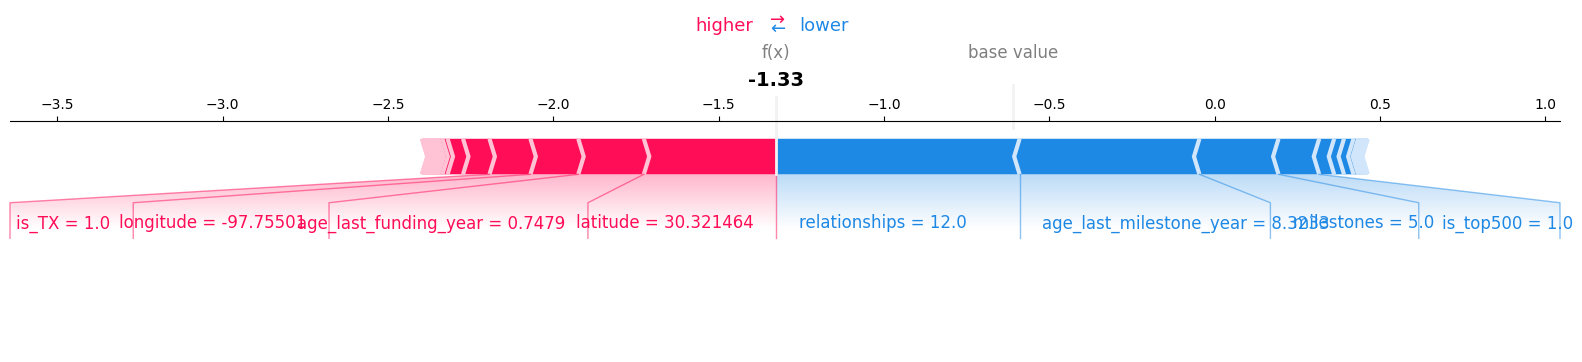


Caso 8 - Índice 440


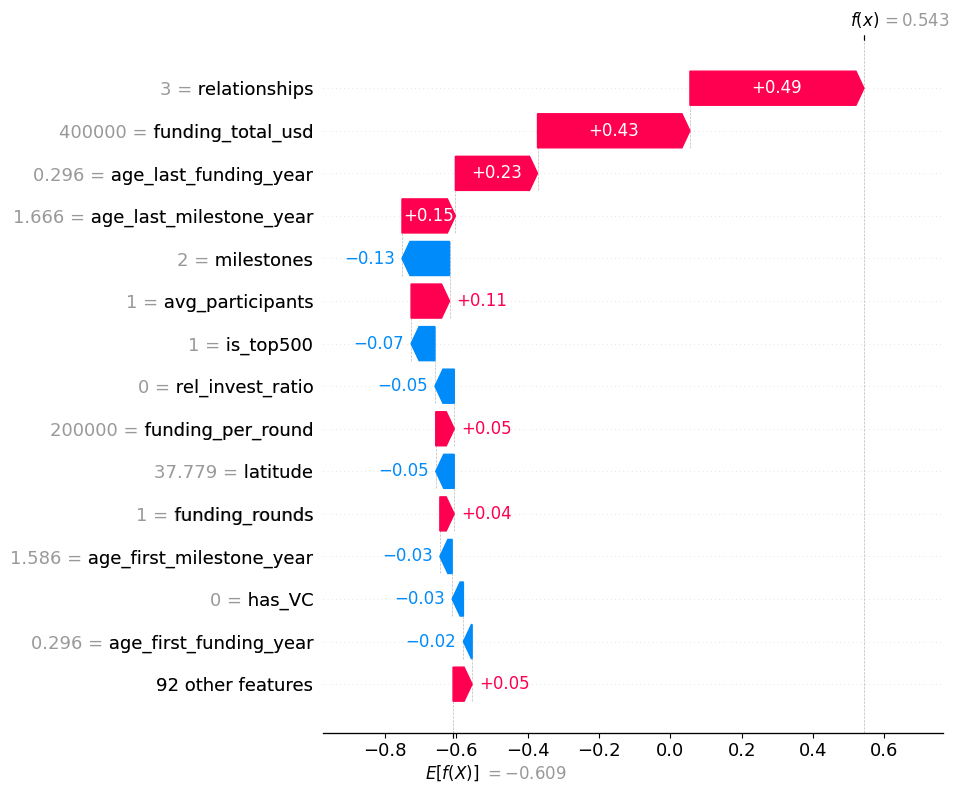

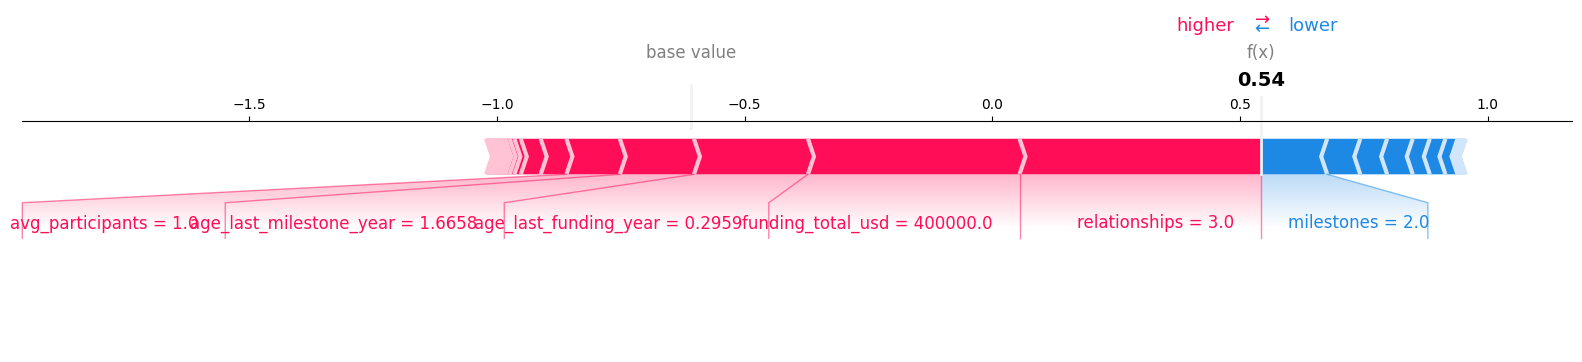


Caso 9 - Índice 813


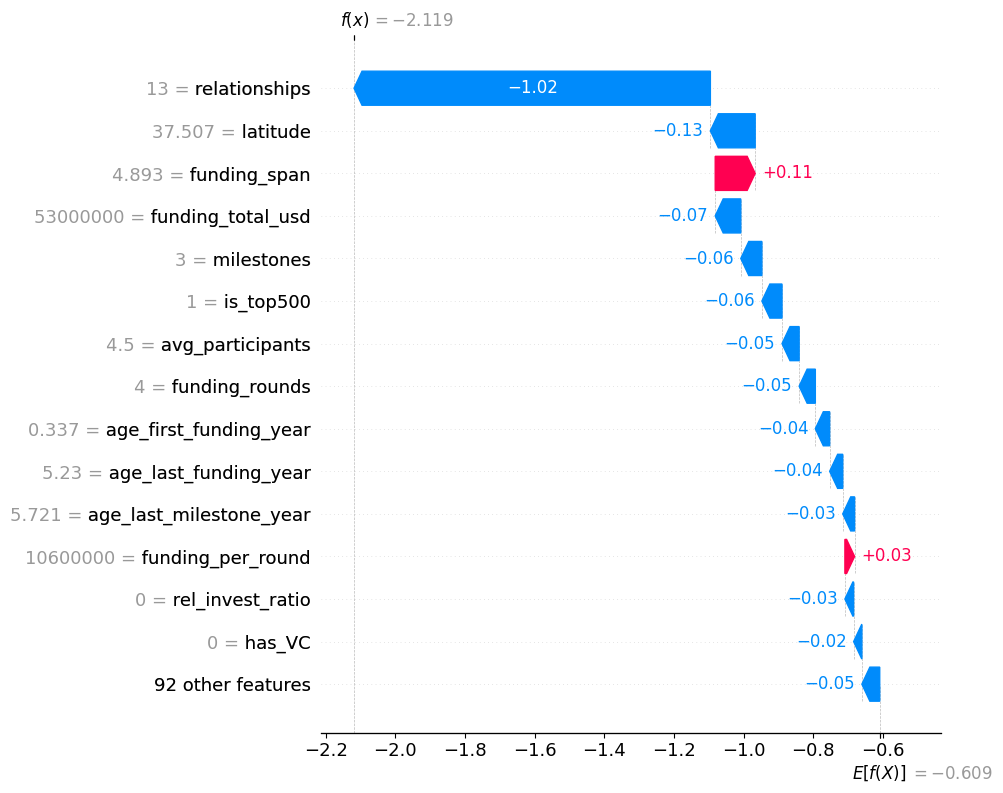

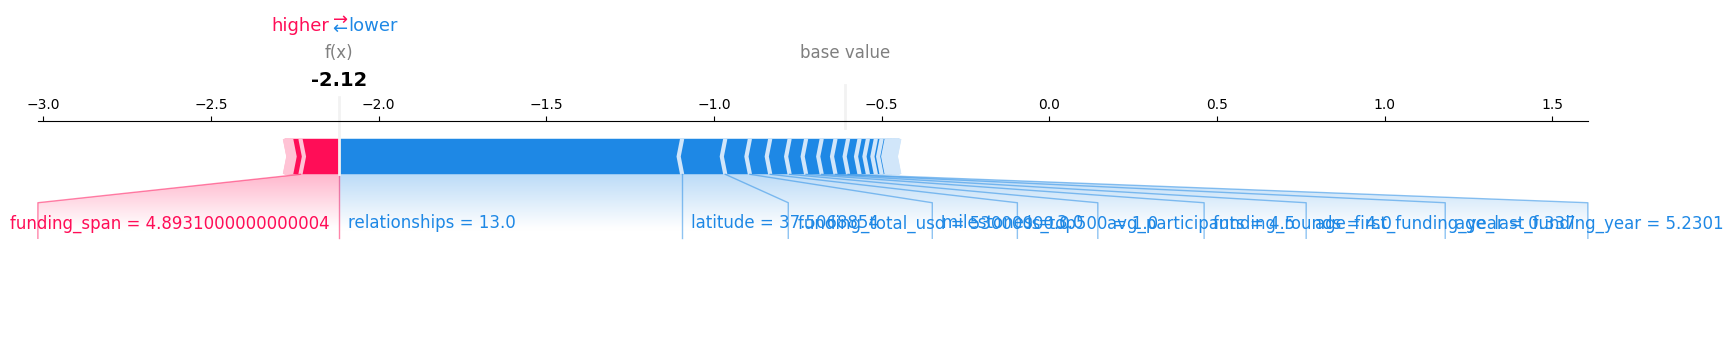


Caso 10 - Índice 552


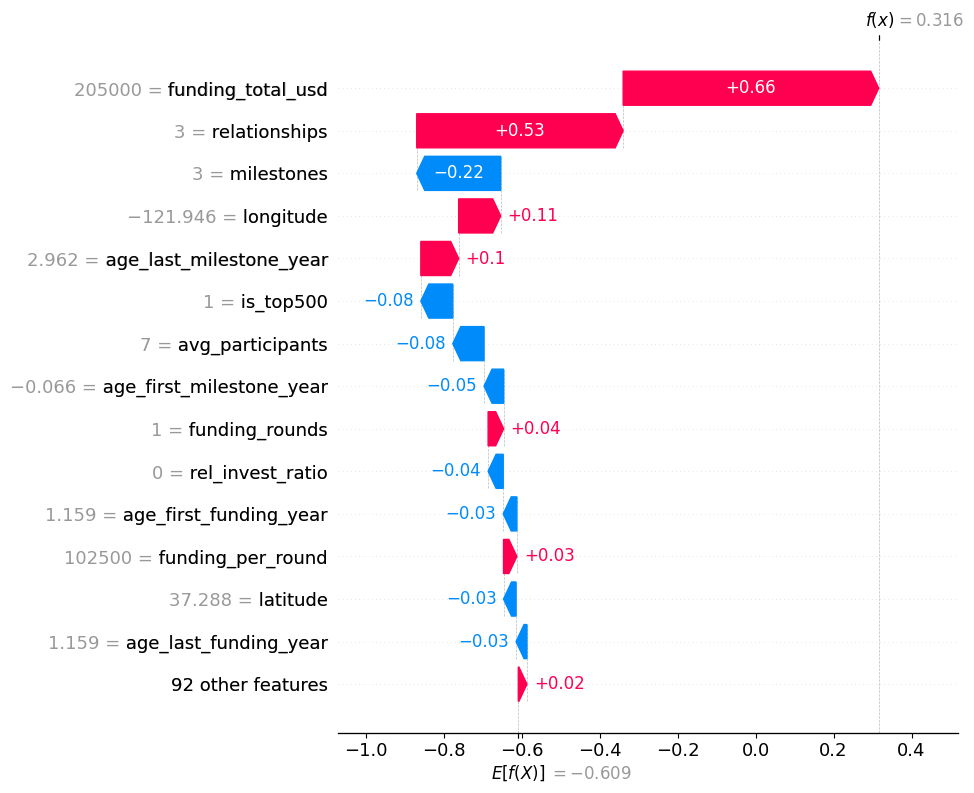

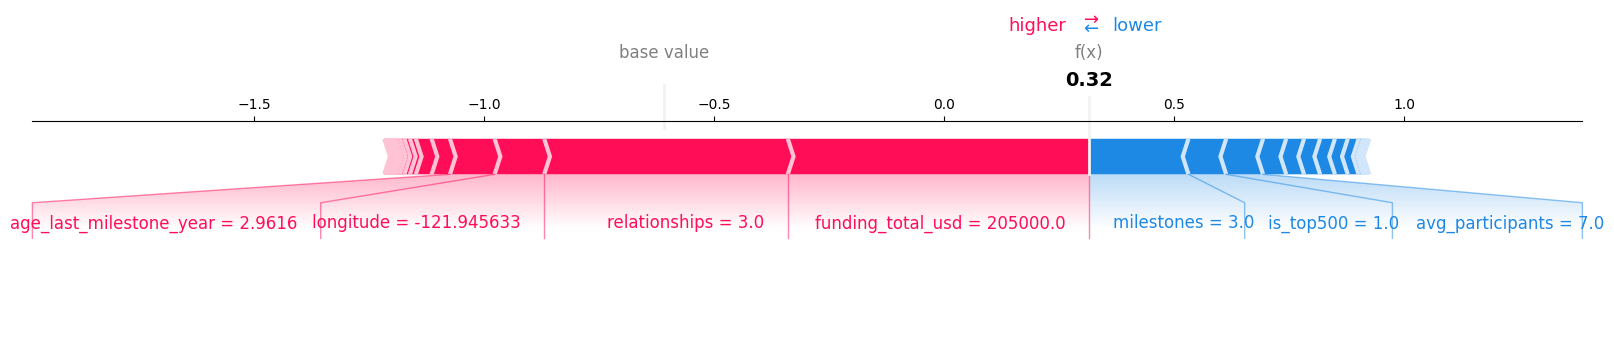

In [ ]:
import shap
import matplotlib.pyplot as plt

# SHAP explainer
explainer = shap.TreeExplainer(best_xgb)

# SHAP values completos
shap_values_full = explainer(X_valid_selected)

# Os valores shap já estão no formato (n_amostras, n_features)
shap_values_correct = shap_values_full.values

# expected_value também é único
expected_value_correct = explainer.expected_value

for i in range(len(X_valid_selected)):

    x_row = X_valid_selected.iloc[i]
    idx = x_row.name

    print(f"\nCaso {i+1} - Índice {idx}")

    # Criar objeto SHAP Explanation no formato correto
    shap_obj = shap.Explanation(
        values=shap_values_correct[i],
        base_values=expected_value_correct,
        data=x_row.values,
        feature_names=X_valid_selected.columns
    )

    # ----- WATERFALL PLOT CORRETO -----
    shap.plots.waterfall(shap_obj, max_display=15)
    plt.show()

    # ----- FORCE PLOT CORRETO -----
    shap.force_plot(
        expected_value_correct,
        shap_values_correct[i],
        x_row,
        matplotlib=True
    )
    plt.show()


### Interprete os resultados dos 10 clientes sob a ótica de quais features foram relevantes para cada cliente.


## Caso 1 – Índice 22  
**Predição final:** alta probabilidade de aquisição.

**Principais fatores que aumentaram a predição:**
- `relationships` apresentou o maior impacto positivo, indicando forte conectividade com investidores e parceiros.  
- `age_last_milestone_year` baixo sugere atividade recente e relevante.  
- `funding_total_usd` também empurrou a predição para cima.  
- `is_top500 = 0` e `milestones = 1` contribuíram positivamente.

**Principais fatores que reduziram a predição:**
- `age_first_funding_year`, `funding_span` e `age_last_funding_year` indicaram histórico temporal mais longo.  
- Algumas variáveis geográficas (latitude) tiveram impacto negativo.

**Interpretação:** a empresa mostra sinais estruturados de tração recente e boa rede de relacionamentos, superando os efeitos temporais negativos.

---

## Caso 2 – Índice 301  
**Predição final:** baixa probabilidade de aquisição (risco elevado de fechamento).

**Fatores negativos dominantes:**
- `relationships = 10` apresentou forte redução da predição, sugerindo possível saturação da rede.  
- `age_last_milestone_year` e `milestones` elevados indicam maturidade sem tração recente.  
- `avg_participants` e `funding_span` também contribuíram para queda no score.

**Fatores positivos menores:**
- `is_top500 = 0` e alguns investimentos recentes ajudaram moderadamente.

**Interpretação:** a estrutura do caso indica uma empresa madura, com muitos relacionamentos porém sem avanços recentes suficientes para elevar a probabilidade de aquisição.

---

## Caso 3 – Índice 331  
**Predição final:** baixa probabilidade de aquisição.

**Principais fatores negativos:**
- `age_last_milestone_year` e `age_first_funding_year` muito elevados indicam trajetória longa sem grandes avanços recentes.  
- `funding_rounds` e `longitude` reforçaram o impacto negativo.

**Fatores positivos secundários:**
- `relationships` e `avg_participants` contribuíram positivamente, mas com menor magnitude.

**Interpretação:** predominam fatores temporais e geográficos negativos, indicando risco elevado de fechamento.

---

## Caso 4 – Índice 439  
**Predição final:** muito baixa probabilidade de aquisição.

**Impactos negativos mais fortes:**
- `age_last_milestone_year`, `funding_total_usd` e `funding_rounds` foram os principais redutores da predição.  
- `longitude` e `vc_investment_strength` também exerceram influência negativa.

**Fatores positivos menores:**
- `funding_span`, `milestones` e `has_VC` apresentaram impacto, mas insuficiente.

**Interpretação:** a startup recebeu aportes significativos no passado, porém sem progressos recentes, indicando baixa probabilidade de aquisição.

---

## Caso 5 – Índice 467  
**Predição final:** baixa probabilidade de aquisição.

**Fatores positivos:**
- `funding_total_usd` foi o principal fator que empurrou a predição para cima.  
- `funding_per_round` e `milestones` também foram positivos.

**Fatores negativos:**
- `longitude`, `relationships` e `rel_invest_ratio` puxaram a predição para baixo.

**Interpretação:** apesar dos investimentos relevantes, fatores geográficos e de eficiência de investimento reduziram o score global.

---

## Caso 6 – Índice 442  
**Predição final:** baixa probabilidade de aquisição.

**Impactos negativos mais relevantes:**
- `age_first_funding_year` e `rel_invest_ratio` tiveram maior influência negativa.  
- `relationships` baixos reforçaram a queda.

**Impactos positivos:**
- `funding_total_usd` e `age_last_funding_year` elevaram a predição.

**Interpretação:** o histórico temporal prejudica a empresa, apesar de investimentos relativamente recentes.

---

## Caso 7 – Índice 52  
**Predição final:** baixa probabilidade de aquisição.

**Principais fatores negativos:**
- `relationships` muito elevado.  
- `age_last_milestone_year` alto.  
- `milestones` e coordenadas geográficas desfavoráveis.

**Fatores positivos menores:**
- `funding_total_usd` e `funding_rounds`.

**Interpretação:** a combinação de maturidade elevada e falta de tração recente reduz a chance de aquisição.

---

## Caso 8 – Índice 440  
**Predição final:** probabilidade moderada de aquisição.

**Fatores positivos principais:**
- `relationships` novamente foi o maior impulsionador.  
- `age_last_funding_year` baixo indica funding recente.  
- `funding_total_usd` e `avg_participants` contribuíram positivamente.

**Fatores negativos:**
- `rel_invest_ratio`, latitude e funding_span reduziram o score.

**Interpretação:** empresa com sinais concretos de tração recente e boa rede, apesar de pequenas fragilidades.

---

## Caso 9 – Índice 813  
**Predição final:** muito baixa probabilidade de aquisição.

**Impactos negativos predominantes:**
- `relationships = 13` com forte efeito negativo.  
- `longitude`, `funding_rounds` e `latitude` contribuíram negativamente.  
- Fatores temporais também foram negativos.

**Impactos positivos menores:**
- `funding_total_usd` e `vc_strength`.

**Interpretação:** empresa apresenta sinais de maturidade excessiva e baixa eficiência recente, sugerindo risco elevado de fechamento.

---

## Caso 10 – Índice 552  
**Predição final:** probabilidade levemente positiva de aquisição.

**Principais fatores positivos:**
- `funding_total_usd` foi responsável pelo maior impacto positivo.  
- `relationships` e `funding_rounds` também elevaram a predição.

**Principais fatores negativos:**
- `milestones`, `avg_participants` e `rel_invest_ratio`.

**Interpretação:** apesar de algumas fragilidades operacionais, o volume de investimento e o nível de conexões elevaram a probabilidade final acima da média.

